# Test of bespoke neural network

Import necessary modules:

In [1]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
from torchviz import make_dot
import time

from modules.helper_functions_tsp import (find_problem_size,
                                          find_distances_array,
                                          cost_fn_fact, 
                                          cost_fn_tensor, 
                                          calculate_hot_start_data
                                          #hot_start, 
                                          #hot_start_list_to_string,
                                          )

from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model,
                                         set_up_input_no_hot_start,
                                         )

from modules.graph_functions import plot_sine_activation

from classes.MyDataLogger import MyDataLogger, MySubDataLogger

from modules.config import PRINT_FREQUENCY

Set up constants:

In [2]:
datalogger = MyDataLogger()
sdl = MySubDataLogger(runid = datalogger.runid)
sdl.update_general_constants_from_config()
sdl.update_ml_constants_from_config()
sdl.validate_input()

SubDataLogger instantiated.  Run ID = 20251013-09-37-45 - 09-37-45


Read in data, report on data read and validate distance array:

In [3]:
distance_array, sdl.best_dist = find_distances_array(sdl.locations, print_comments=True)

Reading distance data
Data will be read from filename networks\five_d.txt.
It is known that the shortest distance is 19


Evaluate cost function and clear cache:

In [4]:
cost_fn = cost_fn_fact(sdl, distance_array)
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [5]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda:0


Find problem size:

In [6]:
sdl.qubits = find_problem_size(sdl)
print(f'There are {sdl.qubits} qubits needed for {sdl.locations} locations in the {sdl.formulation} formulation.')

There are 5 qubits needed for 5 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [ ]:
if sdl.hot_start:
    bin_hot_start_list, sdl.hot_start_dist = calculate_hot_start_data(sdl, 
                                                                    distance_array,
                                                                    cost_fn,
                                                                    print_results=True,
                                                                    )
    bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
    print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
    distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
    print(f'The hot start distance is {sdl.hot_start_dist:.2f}, compared to a best distance of {sdl.best_dist:.2f}.')

The hot start location list is [3, 2, 1, 4]
This is equivalent to a binary list: [1, 0, 0, 1, 0]
The hot start distance is 21.0, compared to a best distance of 19.
bin_hot_start_list_tensor = tensor([[1, 0, 0, 1, 0]])
The hot start distance is 21.00, compared to a best distance of 19.00.


Set up input as repeated hot start tensor calculated above:

In [8]:
if sdl.hot_start:
    unrepeated_input = bin_hot_start_list_tensor.float().to(device)
    my_input = unrepeated_input.repeat(sdl.shots, 1).requires_grad_(True)
else:
    my_input, unrepeated_input = set_up_input_no_hot_start(sdl, device)

In [9]:
unrepeated_input.size()

torch.Size([1, 5])

In [10]:
print(unrepeated_input.size())

torch.Size([1, 5])


Set up model with gradient required:

In [11]:
model = MyModel(sdl, cost_fn).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [12]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 60 parameters in total, of which 60 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

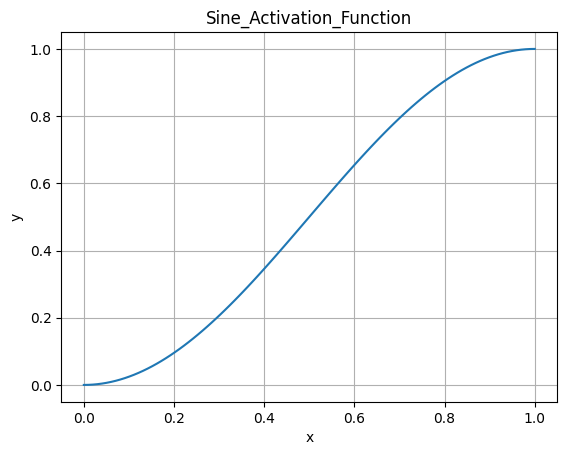

In [13]:
plot_sine_activation()

Print out model details including graph

{'fc1.weight': Parameter containing:
tensor([[ 0.9658,  0.0073,  0.0268,  0.0599, -0.0980],
        [ 0.0225,  1.0528,  0.0356, -0.1044, -0.0459],
        [-0.0805,  0.0323,  0.9710, -0.0204,  0.0381],
        [-0.0056,  0.0444,  0.1184,  1.0771, -0.0291],
        [ 0.0522,  0.0295,  0.0384,  0.0352,  1.0665]], device='cuda:0',
       requires_grad=True), 'fc1.bias': Parameter containing:
tensor([-0.0312, -0.0566, -0.0235, -0.0929, -0.0208], device='cuda:0',
       requires_grad=True), 'fc2.weight': Parameter containing:
tensor([[ 0.9180,  0.0132, -0.1131,  0.0313, -0.0233],
        [-0.0461,  1.0840, -0.0796, -0.0547,  0.0751],
        [-0.0307,  0.0425,  1.0173, -0.0510,  0.0324],
        [ 0.0323, -0.0560,  0.0482,  0.9981,  0.0921],
        [ 0.0709,  0.0555,  0.0044, -0.0822,  0.9648]], device='cuda:0',
       requires_grad=True), 'fc2.bias': Parameter containing:
tensor([ 0.0628, -0.0234,  0.0159, -0.0848,  0.0867], device='cuda:0',
       requires_grad=True)}


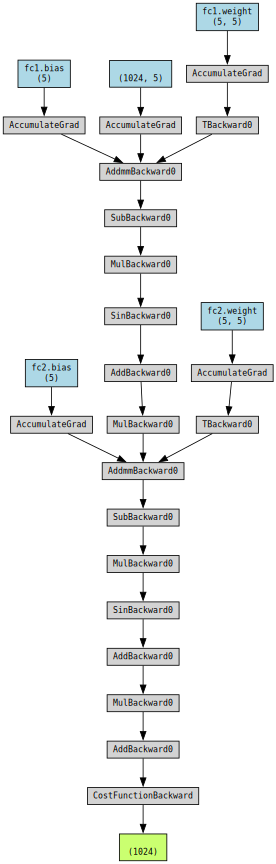

In [14]:
output = model(my_input)
lowest_cost = output.min()
filename = sdl.graph_sub_path.joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

Set up criterion, optimizer and target ready to train model.

In [15]:
target, criterion, optimizer = get_ready_to_train(model, 
                                                  sdl.gradient_type, 
                                                  sdl.lr, 
                                                  sdl.weight_decay, 
                                                  momentum = sdl.momentum
                                                  )

Train model and print out results:

In [16]:

t0 = time.time()
sdl.best_dist_found, sdl.iteration_found, sdl.index_list, sdl.average_list, sdl.lowest_list =\
output_data = train_model(sdl.iterations,
                          model, 
                          my_input, 
                          target, 
                          criterion,
                          optimizer,
                          print_results=True,
                          print_frequency=PRINT_FREQUENCY
                          )

sdl.average_list_all.append(sdl.average_list)
sdl.lowest_list_all.append(sdl.lowest_list)
t1 = time.time()
elapsed = t1-t0
print(f'The time taken to run the code is {elapsed:.3f} seconds')
sdl.elapsed = elapsed
sdl.update_cache_statistics(cost_fn)
sdl.save_results_to_csv()
sdl.save_detailed_results()

Epoch 0, Average cost: 21.164 Epoch min cost:21.000, Lowest Cost to date: 21.000
Epoch 0, fc1.weight grad: 2292.02
Epoch 0, fc1.bias grad: 1620.71
Epoch 0, fc2.weight grad: 4033.47
Epoch 0, fc2.bias grad: 2851.17
Epoch 10, Average cost: 21.771 Epoch min cost:19.000, Lowest Cost to date: 19.000
Epoch 10, fc1.weight grad: 315332.91
Epoch 10, fc1.bias grad: 222974.11
Epoch 10, fc2.weight grad: 14420.16
Epoch 10, fc2.bias grad: 8192.60
Epoch 20, Average cost: 23.436 Epoch min cost:19.000, Lowest Cost to date: 19.000
Epoch 20, fc1.weight grad: 555026.00
Epoch 20, fc1.bias grad: 392462.75
Epoch 20, fc2.weight grad: 4248.17
Epoch 20, fc2.bias grad: 3230.69
Epoch 30, Average cost: 23.814 Epoch min cost:19.000, Lowest Cost to date: 19.000
Epoch 30, fc1.weight grad: 891779.44
Epoch 30, fc1.bias grad: 630583.62
Epoch 30, fc2.weight grad: 6625.35
Epoch 30, fc2.bias grad: 5428.63
Epoch 40, Average cost: 23.342 Epoch min cost:19.000, Lowest Cost to date: 19.000
Epoch 40, fc1.weight grad: 3297351.50


In [17]:
print(f'The lowest cost found was {sdl.best_dist_found:.3f} at epoch {sdl.iteration_found}.')
print(f'The best known cost is {sdl.best_dist:.3f}')
if sdl.hot_start:
    print(f'the hot start cost was {sdl.hot_start_dist:.3f}.')

The lowest cost found was 19.000 at epoch 1.
The best known cost is 19.000
the hot start cost was 21.000.


Plot loss ratio by epoch:

Graph for Run ID: 20251013-09-37-45-09-37-45 being saved to graphs\20251013-09-37-45\09-37-45.png


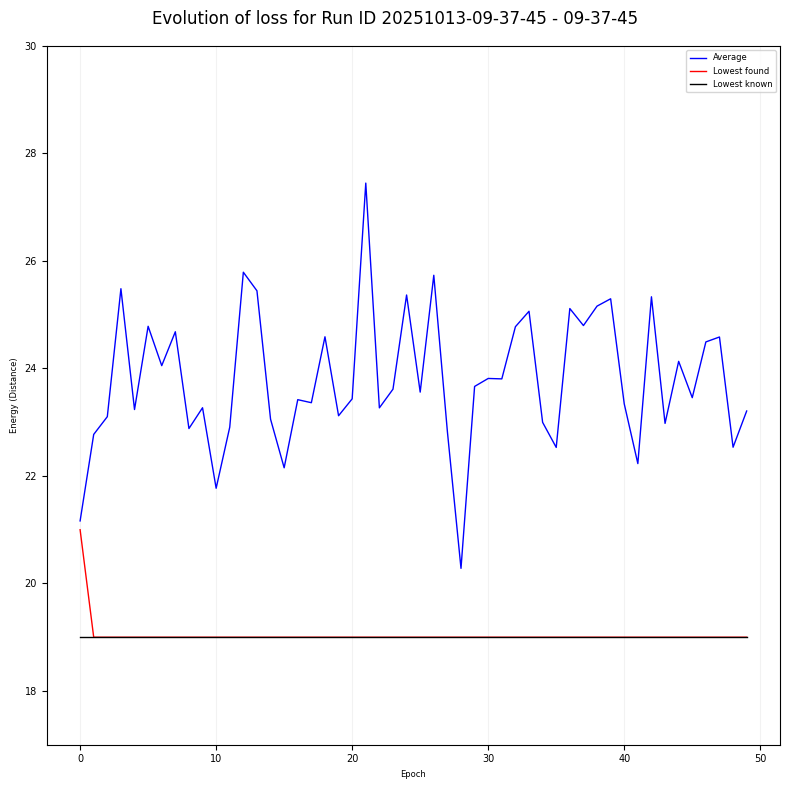

In [18]:
sdl.save_plot()


Print out parameters:

In [19]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[ 2.0998e+04,  7.2790e-03,  2.6820e-02,  2.0997e+04, -9.7989e-02],
        [ 1.1032e+04,  1.0526e+00,  3.5544e-02,  1.1032e+04, -4.5860e-02],
        [-1.0997e+04,  3.2309e-02,  9.7075e-01, -1.0997e+04,  3.8119e-02],
        [ 1.7556e+03,  4.4387e-02,  1.1836e-01,  1.7567e+03, -2.9128e-02],
        [-5.6557e+03,  2.9481e-02,  3.8356e-02, -5.6557e+03,  1.0663e+00]],
       device='cuda:0', requires_grad=True)
bias: Parameter containing:
tensor([ 20996.7715,  11031.7148, -10997.0898,   1755.4771,  -5655.7354],
       device='cuda:0', requires_grad=True)
weight: Parameter containing:
tensor([[ -51.0524,  -27.7421,   11.4696, -126.9452,  -78.3440],
        [  -5.0258,  -21.5629,   20.1524,   36.0594, -113.8010],
        [ -90.1556, -146.6969,  -80.3922,  -20.8355,  -25.5831],
        [   1.2916,   35.4331,   40.5838,  -19.5812,  -45.3468],
        [ 112.8674,   27.8021,   22.9477,   68.4583,   20.3325]],
       device='cuda:0', requires_grad=True)
bias